C:\Users\Max\Anaconda3\lib\site-packages\ipykernel\__main__.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


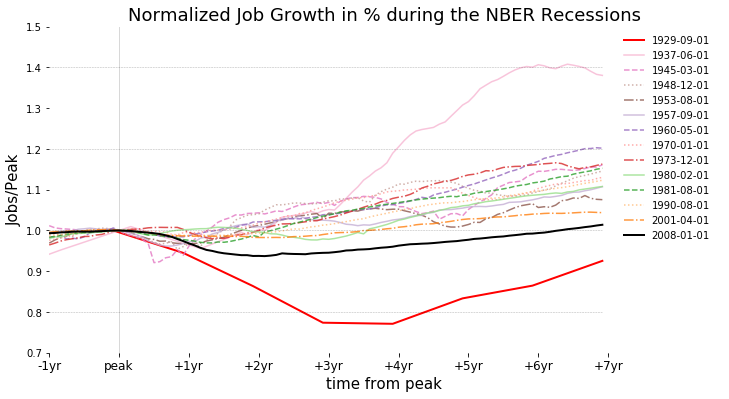

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas_datareader import data, wb
import datetime

start = datetime.datetime(1929, 8, 1)
end = datetime.datetime(2016,10,1)
nber = data.DataReader('USREC', 'fred', start, end)
payems1 = data.DataReader('PAYEMS', 'fred', start, end)
payems = pd.read_csv(r"C:\Users\Max\Documents\OSM_BootCampExercises\Computation\Wk2_Visualization\payems.csv",
                  skiprows=5, parse_dates=True)

len(nber.loc[:'1938-12-01'])
early = payems[:11]
early['num'] = np.concatenate([np.arange(0,10*12, step=12), np.array([113])])
vals = np.arange(0, 113)
payems_interpl = np.interp(vals, early.num, early.payems)

payems_long = np.concatenate((payems_interpl, payems1.PAYEMS.values))

nber['payems'] = payems_long
nber['pay_gr'] = np.log(nber.payems) - np.log(nber.payems.shift(1))

nber['count'] = np.arange(len(nber))
w = np.concatenate([np.array([0]), nber.USREC.values])
group_split = np.array([ i for i, (x, y) in enumerate(zip(w[:-1],w[1:])) if x!=y])
groups = group_split.copy().reshape((14, 2))

select = np.zeros([len(nber), 14], dtype=bool)
for i,s  in enumerate(groups[:,0]):
    if s < 12:
        select[0:s+(12*7),i] = True
    else:
        select[s-12:s+(12*7),i] = True

lenGR = select[:,0].sum()

peak_dates = list(nber.index[groups[:,0]].astype(str))
recessions = pd.DataFrame(np.zeros((96, 14)), columns=peak_dates)
for i in range(14):
    col = peak_dates[i]
    this_recession = select[:,i]
    vals = nber.payems[this_recession].values
    vals = vals[~np.isnan(vals)]
    if i == 0:
        subset = 0
    else:
        subset = 12
    scale = vals[subset]
    vals_norm = vals / (scale) 
    if i == 0:
        vals_norm = np.concatenate((np.repeat(np.nan,11), vals_norm))
    recessions[col] = vals_norm

tableau20 = [(31, 119, 180), (174, 199, 232), (255, 127, 14), (255, 187, 120),    
             (44, 160, 44), (152, 223, 138), (214, 39, 40), (255, 152, 150),    
             (148, 103, 189), (197, 176, 213), (140, 86, 75), (196, 156, 148),    
             (227, 119, 194), (247, 182, 210), (127, 127, 127), (199, 199, 199),    
             (188, 189, 34), (219, 219, 141), (23, 190, 207), (158, 218, 229)]    
    
for i in range(len(tableau20)):    
    r, g, b = tableau20[i]    
    tableau20[i] = (r / 255., g / 255., b / 255.)  

new_ticks = ['-1yr', 'peak', '+1yr', '+2yr',
             '+3yr', '+4yr', '+5yr', '+6yr', '+7yr']

recessions.columns = nber.iloc[list(groups[:,0])].index.astype(str)
#%%
from itertools import cycle
linestyles = ['-', '--', ':', '-.', ]
linecycler = cycle(linestyles)
ticks_pos = np.arange(0, 97, step=12)

fig, ax = plt.subplots(figsize=(12,6));
for i, rec in enumerate(recessions.columns):
    if i == 0:
        ax.plot(recessions[rec], '-', lw=2, label=rec, color='red')
    elif i == 13:
        ax.plot(recessions[rec], '-', lw=2, label= rec, color='black')
    else:
        ax.plot(recessions[rec], next(linecycler), label=rec, alpha=0.8, color=tableau20[-i-6])
ax.set_xlim(0, 115)
ax.set_ylim(.7, 1.5)
for y in np.arange(0.8, 1.5, 0.2):    
    ax.plot(np.arange(0, 96), np.repeat(y, 96), "--", lw=0.5, color="black", alpha=0.3) 
    
plt.axvline(12, ymin=-0.6, ymax = 1.1, linewidth=0.5, alpha=0.3, color='k')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_bounds(0, 96)
ax.set_xlabel('time from peak', fontsize=15)
ax.set_ylabel('Jobs/Peak', fontsize=15)
ax.set_xticks(ticks_pos)
# Set ticks labels for x-axis
ax.set_xticklabels(new_ticks, fontsize=12)
ax.set_xticks(ticks_pos, new_ticks)
plt.title('Normalized Job Growth in % during the NBER Recessions', fontsize=18)
plt.legend(frameon=False)
plt.show();

### Answers:
#### j)
In the recession that startet in March 1945, the number of jobs dropped even faster in the first year after the peak than in the Great Depression or the Great Recession. However, The Great Depression has been accompanied by the largest job losses relative to its peak value than any other of the NBER recession. Moreover, it has taken longer than any of the other recession to recover (in terms of jobs).

#### k)
In terms of relative job losses compared to the peak value the Great Depression has been the worst. Keep in mind that this graph is not able to shed light on absolute job losses, as it has been normalized.